<h1 style="align: center;font-size: 18pt;">Albocycline</h1>

<hr style="height:2.5px">

Summary: In our previous example we showed in detail how to calculate the consistency of theoretical modeling with experiment. The user gained insight on how to run `biceps` calculations in full. In this example, we will repeat the process will less detail for another system.  In addition, this example will include the code for `multiprocessing` lambda values. Note that 1M steps for tutorial purposes. 

To convert this Jupyter Notebook into a script use the following command:

```
$ jupyuter nbconvert --to python Albocycline.ipynb
```

<hr style="height:2.5px">

In [1]:
import sys, os, glob, pickle
import numpy as np
import biceps
import multiprocessing as mp

BICePs - Bayesian Inference of Conformational Populations, Version 2.0


In [2]:
####### Data and Output Directories #######
energies = np.loadtxt('../../datasets/albocycline/albocycline_QMenergies.dat')*627.509  # convert from hartrees to kcal/mol
energies = energies/0.5959   # convert to reduced free energies F = f/kT
energies -= energies.min()  # set ground state to zero, just in case
data = biceps.toolbox.sort_data('../../datasets/albocycline/noe_J')
res = biceps.toolbox.list_res(data)
outdir = 'results_ref_normal'
biceps.toolbox.mkdir(outdir)

####### Parameters #######
nsteps=1000000
maxtau = 1000
lambda_values = [0.0, 0.5, 1.0]
ref = ['uniform', 'exp']
uncern = [[0.05, 20.0, 1.02], [0.05, 5.0, 1.02]]

In [3]:
####### Multiprocessing Lambda values #######
def mp_lambdas(Lambda):
    ####### MCMC Simulations #######
    ensemble = []
    for i in range(energies.shape[0]):
        ensemble.append([])
        for k in range(len(data[0])):
            File = data[i][k]
            R = biceps.init_res(PDB_filename='../../datasets/albocycline/pdbs/0.pdb', lam=lam,
                energy=energies[i], ref=ref[k], data=File,
                uncern=uncern[k], gamma=[0.2, 5.0, 1.02])
            ensemble[-1].append(R)
    sampler = biceps.PosteriorSampler(ensemble)
    sampler.sample(nsteps=nsteps)
    sampler.traj.process_results(outdir+'/traj_lambda%2.2f.npz'%(lam))
    sampler.traj.read_results(os.path.join(outdir,
        'traj_lambda%2.2f.npz'%lam))
    outfilename = 'sampler_lambda%2.2f.pkl'%(lam)
    fout = open(os.path.join(outdir, outfilename), 'wb')
    pickle.dump(sampler, fout)
    fout.close()
    print('...Done.')

In [4]:
# Check the number of CPU's available
print("Number of CPU's: %s"%(mp.cpu_count()))
p = mp.Pool(processes=len(lambda_values)) # knows the number of CPU's to allocate
jobs = []
for lam in lambda_values:
    process = p.Process(target=mp_lambdas, args=(lam,))
    jobs.append(process)
    jobs[-1].start() # Start the processes
    active_processors = [jobs[i].is_alive() for i in range(len(jobs))]
    if (len(active_processors) == len(lambda_values)) and all(active_processors) == True:
        while all(active_processors) == True:
            active_processors = [jobs[i].is_alive() for i in range(len(jobs))]
        inactive = int(np.where(np.array(active_processors) == False)[0])
        jobs[inactive].terminate()
        jobs.remove(jobs[inactive])
for job in jobs:
    job.join() # will wait until the execution is over...
p.close()

Number of CPU's: 4

Accepted 65.92949999999999 % 


Accepted [32.6643 30.731  30.731   2.5342] % 


Accepted 69.62559999999999 % 


Accepted [32.6185 30.2828 30.2828  6.7243] % 


Accepted 70.99839999999999 % 


Accepted [32.6615 30.5969 30.5969  7.74  ] % 

...Done.
...Done.
...Done.


Loading results_ref_normal/traj_lambda0.00.npz ...
Loading results_ref_normal/traj_lambda0.50.npz ...
Loading results_ref_normal/traj_lambda1.00.npz ...
not all state sampled, these states [ 9 48] are not sampled
not all state sampled, these states [ 4  5  7  9 15 16 21 25 27 28 34 40 42 44 48 51 54 58 76 77 81 87 94 95
 98] are not sampled
Loading results_ref_normal/sampler_lambda0.00.pkl ...
Loading results_ref_normal/sampler_lambda0.50.pkl ...
Loading results_ref_normal/sampler_lambda1.00.pkl ...
lam = [0.0, 0.5, 1.0]
nstates 100
Writing results_ref_normal/BS.dat...
...Done.
Writing results_ref_normal/populations.dat...
...Done.


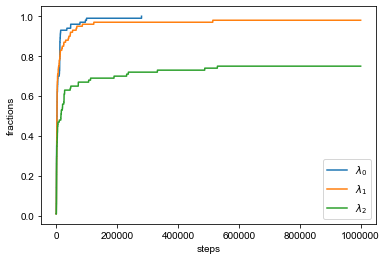

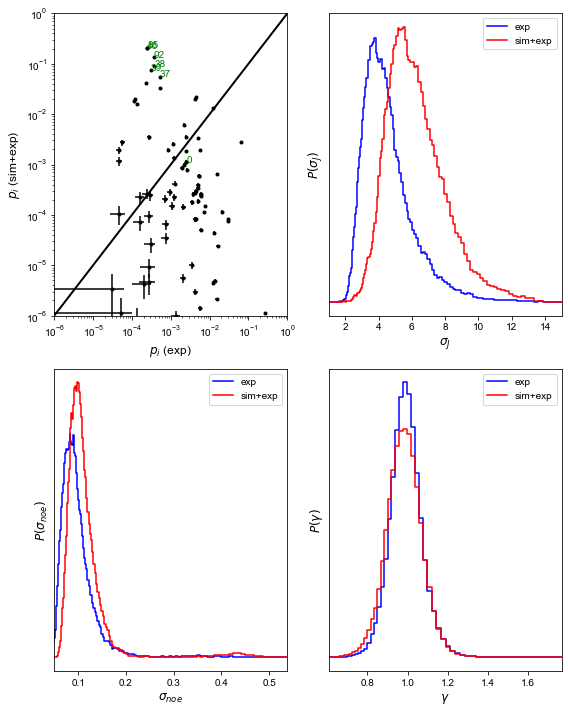

In [5]:
####### Posterior Analysis #######
%matplotlib inline
A = biceps.Analysis(states=100, resultdir=outdir+"/",
    BSdir='BS.dat', popdir='populations.dat',
    picfile='BICePs.pdf')
A.plot()

<h6 style="align: justify;font-size: 12pt"># <span style="color:red;">NOTE</span>: The following cell is for pretty notebook rendering</h6>

In [7]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../../theme.css", "r").read()
    return HTML(styles)
css_styling()